## Run throught some Clustering Approaches on the Chicago Crime Data:
----------

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import utm
import shapely as shp
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
class SpatialHandler():
    
    def __init__(self):
        pass
    
    def set_data(self, dataIN):
        self.dataIN = dataIN
          
    def latlon_toUTM(self, lat, long):
        '''
            Input: Latitude and Longitude
            Output: Longitude and Latitude UTM projections 
        '''
        tup = utm.from_latlon(lat,long)
        lat_cnvrt = tup[0]
        long_cnvrt = tup[1]

        return long_cnvrt, lat_cnvrt
    
    def spatial_transformations(self, column_Lat, column_Lon, **kwargs):
        utmProj = []
        geomPoints_UTM = []
        geomPoints_LatLon = []
        
        kwargsKeys = kwargs.keys()
        for lat, lon in zip(self.dataIN[column_Lat], self.dataIN[column_Lon]):
            if 'getUTM' in kwargsKeys:
                columnOut_1 = self.latlon_toUTM(lat, lon)
                utmProj.append(columnOut_1) 
                
            if 'cnvrt_toPoints' in kwargsKeys and 'UTM' in kwargs['cnvrt_toPoints']:
                try:
                    geomPoints_UTM.append(Point(columnOut_1))   
                except UnboundLocalError:
                    raise UnboundLocalError('You should first transform the data into UTM')
                    
            
            if 'cnvrt_toPoints' in kwargsKeys and 'LatLon' in kwargs['cnvrt_toPoints']:
                geomPoints_LatLon.append(Point(lat,lon))

                
        return (np.array(utmProj, dtype='float64'), 
                gpd.GeoSeries(geomPoints_UTM), 
                gpd.GeoSeries(geomPoints_LatLon))
    
    
class Plot():
    def __init__(self):
        self.newPlot = None
        self.basePlot = None
        self.axPointer = None
        
    def set_data(self, dataIN):
        self.dataIN = dataIN
        
    def set_figure(self, numRows=1, numColumns=1, lenXaxis=40, lenYaxis=15):
        self.fig, self.ax = plt.subplots(numRows, numColumns, figsize=(lenXaxis, lenYaxis), facecolor='w', edgecolor='k')
        if numRows>1 or numColumns>1:
            self.ax = self.ax.ravel()
            self.axPointer = 0
        
    def base_plot(self, color='white', dataIN=None):
        if self.axPointer != None:
            if dataIN != None:
                self.basePlot = dataIN.plot(ax=self.ax[self.axPointer], color=color)
            else:
                self.basePlot = self.dataIN.plot(ax=self.ax[self.axPointer], color=color)

            self.axPointer += 1
        else:
            if dataIN != None:
                self.basePlot = dataIN.plot(ax=self.ax, color=color)
            else:
                self.basePlot = self.dataIN.plot(ax=self.ax, color=color)
            
    def add_plot(self, dataIN):
        if self.newPlot == None:
            self.newPlot = dataIN.plot(ax=self.basePlot, marker='o', color='red', markersize=7)
        else:
            self.newPlot = dataIN.plot(ax=self.newPlot, marker='o', color='red', markersize=7)
            

In [3]:
chicago_crm_pointsDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/Crimes2015_NA_rmv_sampl.csv'
chicagoCrime = pd.read_csv(chicago_crm_pointsDir)

# Renaming Dataset:
chicagoCrime = chicagoCrime[['Latitude', 'Longitude']]
chicagoCrime.head()

# Spatial Handler
objSpHandler = SpatialHandler()
objSpHandler.set_data(chicagoCrime)
kwargs = {'getUTM':True, 'cnvrt_toPoints':['UTM', 'LatLon']}
(utmProj, geomPoints_UTM, geomPoints_LatLon) =  objSpHandler.spatial_transformations('Latitude', 
                                                                                    'Longitude', 
                                                                                    **kwargs)

# Now we add the columns to the DataFrame
chicagoCrime['latUTM'] = utmProj[:,0]
chicagoCrime['lonUTM'] = utmProj[:,1]
chicagoCrime['geometryUTM'] = geomPoints_UTM
chicagoCrime['geometryLatLan'] = geomPoints_LatLon

chicagoCrime.head()

,Latitude,Longitude,latUTM,lonUTM,geometryUTM,geometryLatLan
0,41.998718,-87.680163,4.649858e+06,443669.248394,POINT (4649857.621612935 443669.2483944244),POINT (41.998718085 -87.680162979)
1,41.934630,-87.746718,4.642788e+06,438095.172660,POINT (4642787.870839979 438095.1726599361),POINT (41.934629749 -87.746717696)
2,41.923673,-87.786302,4.641601e+06,434802.385543,POINT (4641600.656321065 434802.3855430915),POINT (41.923672617 -87.78630160600001)
3,41.965391,-87.658037,4.646143e+06,445473.280365,POINT (4646142.993461905 445473.2803646126),POINT (41.965390764 -87.658037135)
4,41.884014,-87.730674,4.637157e+06,439377.384825,POINT (4637156.675222915 439377.3848248574),POINT (41.884014312 -87.73067384399999)


### Plots to Vizualize the Data:

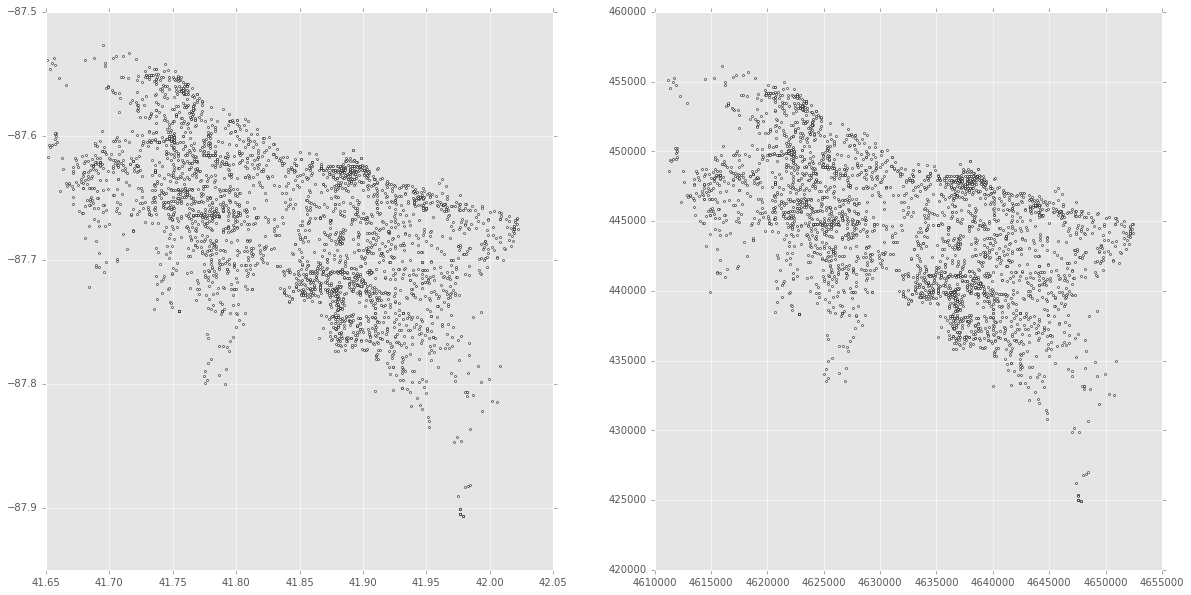

In [4]:
# Figure Frame
obj_plot = Plot()
obj_plot.set_figure(1,2,20,10)

# Plot 1
# We make one of the column as the geometry column
chicagoCrime = chicagoCrime.set_geometry('geometryLatLan')
obj_plot.set_data(chicagoCrime)
obj_plot.base_plot()


# Plot 2
# We make one of the column as the geometry column
chicagoCrime = chicagoCrime.set_geometry('geometryUTM')
obj_plot.set_data(chicagoCrime)
obj_plot.base_plot()


### Simple Clustering Techniques:
----------

In [27]:
# Calculating sparse neighbors, This preprocessing would help us to reduce 1 on 1 compare later with the density algorithm
X = np.array(chicagoCrime[['latUTM','lonUTM']])#[[0,0], [2,0], [0,2]]#[[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
X.shape
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(radius=300)
neigh.fit(X) 
A = neigh.radius_neighbors_graph(X)
A.toarray()

# We would like to print the number of neighbors for some random samples
randNUM = np.random.randint(0,300,50)
print (np.sum(A[randNUM].toarray(), axis=1))

[  2.   4.   1.   1.   4.   1.   1.   3.   1.   8.   6.   1.   4.   1.   1.
   5.   4.   8.   9.   5.   6.   4.   4.  10.   5.   1.  13.   1.   2.   1.
   5.   4.   1.   8.   2.   3.   3.   3.   6.   5.   2.   1.   6.   3.   4.
   9.   2.   1.   2.   2.]


In [24]:
np.sum(np.array([[1,2,3],[4,5,6],[7,8,9]]), axis=1)

array([ 6, 15, 24])